In [1]:
from datetime import datetime
from glob import glob
import pandas as pd
import numpy as np

In [2]:
from matplotlib import patches
import cv2

In [3]:
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [4]:
df   = pd.DataFrame([{'fname': f} for f in glob('/data/2/Sentinel2-crops/T32TPQ/*/20*')])
mask = pd.DataFrame([{'fname': f} for f in glob('/data/2/Sentinel2-crops/T32TPQ/*/crops_segmentation.npy')])

In [5]:
mask['label'] = mask.fname.apply(lambda x: x.split('/')[5])
df['label'] = df.fname.apply(lambda x: x.split('/')[5])
df['date']  = df.fname.apply(lambda x: datetime.strptime(x.split('/')[-1].split('.')[0], '%Y%m%d'))

In [6]:
df = df.groupby('label').apply(lambda x: x.sort_values(by='date', ascending=False).iloc[0])

In [7]:
df = pd.concat([df, mask.set_index('label').fname.rename('cmaps')], axis=1)
df = df.reset_index(drop=True) 

In [8]:
df.head()

,fname,label,date,cmaps
0,/data/2/Sentinel2-crops/T32TPQ/n44168e11547/20...,n44168e11547,2022-08-16,/data/2/Sentinel2-crops/T32TPQ/n44168e11547/cr...
1,/data/2/Sentinel2-crops/T32TPQ/n44168e11563/20...,n44168e11563,2022-08-16,/data/2/Sentinel2-crops/T32TPQ/n44168e11563/cr...
2,/data/2/Sentinel2-crops/T32TPQ/n44168e11579/20...,n44168e11579,2022-08-16,/data/2/Sentinel2-crops/T32TPQ/n44168e11579/cr...
3,/data/2/Sentinel2-crops/T32TPQ/n44169e11515/20...,n44169e11515,2022-08-16,/data/2/Sentinel2-crops/T32TPQ/n44169e11515/cr...
4,/data/2/Sentinel2-crops/T32TPQ/n44169e11531/20...,n44169e11531,2022-08-16,/data/2/Sentinel2-crops/T32TPQ/n44169e11531/cr...


In [9]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib 

# Colormap (same as in the paper)

cm = matplotlib.cm.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,19)]+['w']
cmap = ListedColormap(colors = cus_colors, name='agri',N=20)

label_names =   [
                    "Background","Meadow","Soft winter wheat",
                    "Corn","Winter barley","Winter rapeseed",
                    "Spring barley","Sunflower","Grapevine",
                    "Beet","Winter triticale","Winter durum wheat",
                    "Fruits,  vegetables, flowers","Potatoes",
                    "Leguminous fodder","Soybeans","Orchard",
                    "Mixed cereal","Sorghum","Void label"
                ]

In [13]:
sample = df.sample(1)

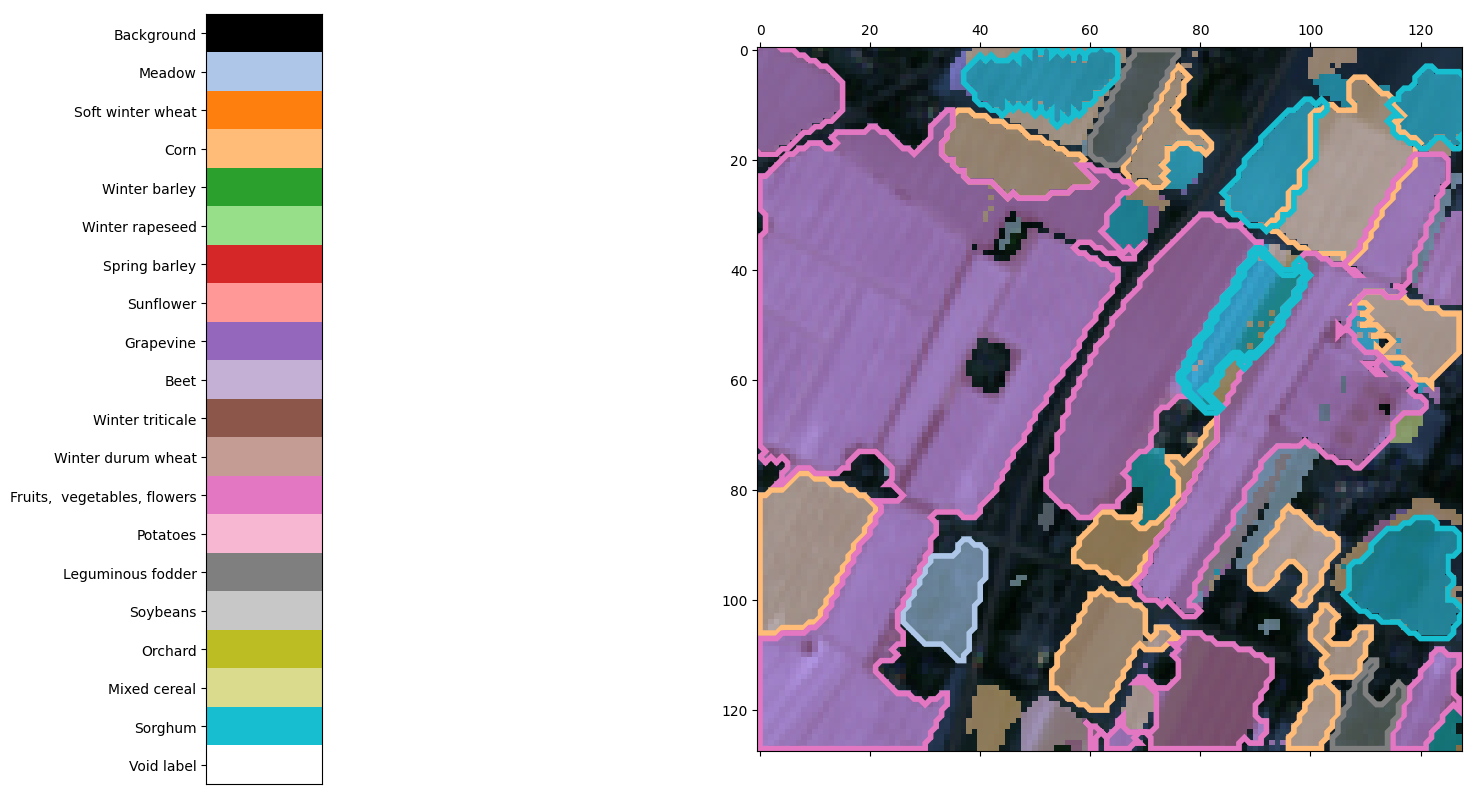

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].matshow(np.stack([np.arange(0, 20) for _ in range(3)], axis=1), cmap = cmap)
ax[0].set_yticks(ticks = range(20), labels=label_names)
ax[0].set_xticks(ticks=[])

image = np.load(sample.iloc[0].fname)[0:3].transpose(1, 2, 0)
image = (image - image.min()) / (image.max() - image.min())
ax[1].imshow(image, interpolation=None)

mask = np.load(sample.iloc[0].cmaps)[0]

labels = np.unique(mask).astype(int)
labels = labels[(labels > 0) & (labels < 19)]

ax[1].matshow(mask,cmap=cmap,vmin=0,vmax=19, alpha=0.5)

for i, l in enumerate(labels):
    c,h= cv2.findContours((mask==l).astype(int), 
                          cv2.RETR_FLOODFILL, 
                          cv2.CHAIN_APPROX_SIMPLE)

    color = cmap.colors[l]

    for co in c[1::2]:
        if PolyArea(co[:,0,0], co[:,0,1]) > 100:
            #poly = patches.Polygon(co[:,0,:], fill=True, alpha=0.3, linewidth=0, color=color)
            #ax[1].add_patch(poly)
            poly = patches.Polygon(co[:,0,:], fill=False, alpha=1, linewidth=4, color=color)
            ax[1].add_patch(poly)
            
plt.show()